In [31]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.special import binom
import matplotlib.pyplot as plt
import time 
import abess
from abess.linear import LinearRegression

In [23]:
'''
S <- stored as p-dim np array of 0,1 indicating which variables active

'''



def compare_to_rows(SS, S):
    # S <- p-dim array, SS <- (m,p) array
    # returns -1 if not present otherwise row number
    logic = np.any(np.all(SS == S, axis =1))
    if logic == True:
        return np.where(logic == True)[0][0]
    else:
        return -1


class ebreg:

    def __init__(self, tuning_parameters):

        #tuning parameters <- dictionary
        self.s = tuning_parameters['s']
        self.epsilon = tuning_parameters['epsilon']
        self.sensitivity_scaling = tuning_parameters['sensitivity_scaling']

        # MCMC parameters
        self.max_iter = tuning_parameters['max_iter']
        
        # some options
        self.standardize = tuning_parameters["standardization"]
        self.initialization = tuning_parameters["initialization"]

    def fit(self, X, y):
        self.n, self.p = X.shape
        #if self.n >= 100: self.burn_in = 500
        # standardize X
        if self.standardize is True:
            scaler1 = StandardScaler(with_mean=True, with_std=False).fit(X)
            X = scaler1.transform(X)

            y = y - y.mean()

        self.X = X
        self.y = y
        

        self.MCMC()

   

    def draw_q(self, S):
        S1 = S.copy()
        s = S.sum()
        idx_0 = np.where(S1 == 0)[0]
        idx_1 = np.where(S1 == 1)[0]
        S1[np.random.choice(idx_1, 1)] = 0
        S1[np.random.choice(idx_0, 1)] = 1

        return S1

    def OLS_pred_and_pi_n(self, S):
        X_S = self.X[:, S == 1]
        y = self.y

        reg = LR(fit_intercept=False).fit(X_S, y)  # what happens when singular
        Y_S = reg.predict(X_S)

        epsilon = self.epsilon
        #sigma2 = self.sigma2_hat
        # gamma = self.gamma
        Du = self.sensitivity_scaling #2 * self.ymax**2 + 2 * self.s * (self.xmax**2) *  self.sensitivity_scaling * sigma2
        # s = S.sum()
        log_pi_n =  - epsilon * np.linalg.norm(y - Y_S) ** 2/(
            2*Du)  # np.log(gamma + alpha/sigma2)
        return Y_S, log_pi_n

    def initialize(self):
        
        S = np.zeros(self.p)
        
        
        if self.initialization == "Lasso":
            reg = LassoCV(n_alphas=100, fit_intercept=False,
                          cv=5, max_iter=2000).fit(self.X, self.y)
            scores = np.abs(reg.coef_)
            s_max_scores_id = np.argsort(scores)[::-1][:s]
            S[s_max_scores_id] = 1
        
        if self.initialization == "MS":
            c = X.T@y/self.n
            c1 = np.abs(c)
            c2 = np.argsort(c1)[::-1][:s]
            S[c2] = 1
        
        else: S[np.random.choice(self.p, self.s, replace= False)] = 1
        
        self.initial_state = S
        
        self.S = S
        
        
        return S

    def MCMC(self):
        max_iter = self.max_iter
        
        # initialize
        S = self.initialize()
        self.S_list = np.array([self.S])
        Y_S, log_pi_n = self.OLS_pred_and_pi_n(self.S)
        self.Y_S_list = np.array([Y_S])
        self.log_pi_n_list = [log_pi_n]
        self.RSS = np.array([np.linalg.norm(self.y - Y_S)**2/np.linalg.norm(self.y)**2])
        #self.F1 = [0]

        

        S = self.S
        y = self.y

        iter1 = 0
        no_acceptances = 0

        while (iter1 < max_iter):

            # proposal draw
            S_new = self.draw_q(S)

            # check if this S has already been seen
            idx = compare_to_rows(self.S_list, S_new)
            if idx == -1:
                Y_S_new, log_pi_n_new = self.OLS_pred_and_pi_n(S_new)
                self.S_list = np.vstack((self.S_list, S_new))
                self.Y_S_list = np.vstack((self.Y_S_list, Y_S_new))
                self.log_pi_n_list.append(log_pi_n_new)
                self.RSS = np.vstack((self.RSS, np.linalg.norm(self.y - Y_S_new)**2/np.linalg.norm(self.y)**2))
                #print(np.linalg.norm(self.y - Y_S_new)**2/np.linalg.norm(self.y)**2)
                
            else:
                Y_S_new = self.Y_S_list[idx]
                log_pi_n_new = self.log_pi_n_list[idx]

            # compute hastings ratio
            R = np.min([1, np.exp(log_pi_n_new - log_pi_n)])
            if stats.uniform.rvs() <= R:
                # accept
                S = S_new
                log_pi_n = log_pi_n_new
                no_acceptances += 1

        

            iter1 += 1

        print('acceptance rate is', no_acceptances/iter1)
        self.acceptance = no_acceptances 


In [24]:
# Example
np.random.seed(1)
n = 900
p = 2000
s = 10
rho = 0.0
Sigma = np.eye(p)*(1-rho) + rho * np.ones((p, p))
X = np.random.uniform(-1, 1, n*p).reshape(n,p)
beta = np.zeros(p)
beta[0:s] = 2 * np.sqrt(s * np.log(p)/n)

#scaler1 = StandardScaler(with_mean=True, with_std=False).fit(X)
#X = scaler1.transform(X)
#X = X
e = np.random.uniform(-1,1,n)
e1 = e/ np.linalg.norm(e)
y = X @ beta + e

In [22]:
S2 = np.zeros(p)
idx = np.random.choice(p, s, replace = False) 
S2[idx] = 1
X_S2 = X[: , S2==1]
lm = LR(fit_intercept=False).fit(X_S2, y)
beta_hat = lm.coef_
np.sum(np.abs(beta_hat))
( np.abs(y).max() + np.abs(X).max()* np.abs(beta_hat).sum())**2

20.571918415947568

In [25]:
tuning_parameters = {'epsilon': 5,
                     'sensitivity_scaling': 20,
                     's'      : s,
                     'max_iter': 20000,
                    'initialization': 'Random',
                    'standardization': True}

model = ebreg(tuning_parameters)


def fit_MCMC(i):
    model.fit(X,y)
    S_hat = np.where(model.S_list[-1]>0)[0]
    S = np.where(beta!=0)[0]
    prec = len(np.intersect1d(S_hat, S))/max(1,len(S_hat))
    recall = len(np.intersect1d(S_hat, S))/len(S)
    F1 = 2/(1/prec + 1/recall)
    return {'RSS': model.RSS, 'F1': F1}
    

num_chains = 5 
from joblib import Parallel, delayed

results = Parallel(n_jobs= num_chains)(delayed(fit_MCMC)(i) for i in range(num_chains))


model_abess = LinearRegression(support_size = s)
model_abess.fit(X, y)
S_abess = np.where(model_abess.coef_!=0)[0]
S = np.where(beta!=0)[0]
prec = len(np.intersect1d(S_abess, S))/max(1,len(S_abess))
recall = len(np.intersect1d(S_abess, S))/len(S)
F1_abess = 2/(1/prec + 1/recall)

RSS_abess = np.linalg.norm(y - X@model_abess.coef_)**2/np.linalg.norm(y)**2
RSS_true = np.linalg.norm(y - X@beta)**2/np.linalg.norm(y)**2

KeyboardInterrupt: 

NameError: name 'results' is not defined

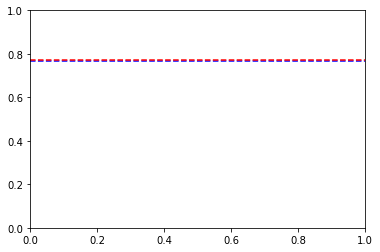

In [30]:
plt.axhline(y = 1- RSS_true, color = 'b', linestyle = '--', label = '$R_{\gamma^*}$')
plt.axhline(y = 1- RSS_abess, color = 'r', linestyle = '--', label = '$R_{\gamma_{BSS}}(non-private)$')

for i in range(num_chains):
    RSS = results[i]['RSS']
    if i==0: plt.plot(range(len(RSS)), (1-RSS), color = 'grey', alpha = 0.3, label = '$R_{\gamma_{BSS}}(\epsilon = $' + 
                      str(tuning_parameters['epsilon']) + ')')
    else: plt.plot(range(len(RSS)), (1-RSS), color = 'grey', alpha = 0.3)
plt.ylim(ymax= 1)
    

plt.xlabel('iterations', size = 13)
plt.ylabel('$R_\gamma$', size = 13)
plt.title()
#plt.yscale('log')  
plt.xscale('log')
plt.legend(fontsize = 13)
plt.show()
name = 'Uniform_design_multiple_MH_chain_'+str(num_chains)+'_epsilon_'+str(tuning_parameters['epsilon'])+'_s_'+str(s)+'_p_'+str(p)+'_n_'+str(n)+'.pdf'
plt.savefig(name)

In [ ]:
F1 = np.mean([results[i]['F1'] for i in range(num_chains)])
F1_dict = {'MH_mean': F1, 'BSS': F1_abess}
np.save('F1'+name, F1_dict)
F1_dict